In [6]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from dataloaders import FacadesDataset, UnpairedFacadesDataset

## Neural architecture

In [7]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim)
        )
    def forward(self, x):
        return x + self.block(x)

In [8]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9):
        """
        :param input_nc: number of input channels
        :param output_nc: number of output channels
        :param ngf: number of base filters
        :param n_blocks: number of residual blocks
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True)
        ]
        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True)
            ]
        # Residual blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]
        # Upsampling (2 times)
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

In [9]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        """
        :param input_nc: number of channels in input image
        :param ndf: nu8mber of base level filters
        :param n_layers: number of convolutional layers
        """
        super(NLayerDiscriminator, self).__init__()
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)]
        self.model = nn.Sequential(*sequence)
    def forward(self, x):
        return self.model(x)

### Training

In [5]:
def train_cyclegan():
    # Hyperparameters (from article)
    epochs = 100
    save_each = 25
    batch_size = 1  # the article used batch=1 for CycleGAN
    lr = 0.0002
    lambda_cycle = 10.0
    lambda_identity = 5.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Используем устройство:", device)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Uploading the dataset (unpaired)
    dataset = UnpairedFacadesDataset(root_dir='facades/train', transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initializing generators:
    # G: A (mask) -> B (photo), F: B (Photo) -> A (mask)
    netG = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9).to(device)
    netF = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9).to(device)

    # Initializing discriminators:
    # D_A distinguishes real masks from generated ones
    # D_B distinguishes real photos from generated ones
    netD_A = NLayerDiscriminator(input_nc=3).to(device)
    netD_B = NLayerDiscriminator(input_nc=3).to(device)

    # Loss functions
    # For adversarial losses, we use MSE (as in the original CycleGAN implementation)
    criterion_GAN = nn.MSELoss()
    criterion_cycle = nn.L1Loss()
    criterion_identity = nn.L1Loss()

    # Label tensors (real = 1, fictitious = 0)
    real_label = 1.0
    fake_label = 0.0

    # Optimizers (for generators we combine the parameters G and F)
    optimizer_G = optim.Adam(list(netG.parameters()) + list(netF.parameters()), lr=lr, betas=(0.5, 0.999))
    optimizer_D_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

    # Learning cycle
    for epoch in range(epochs):
        for i, (real_A, real_B) in enumerate(dataloader):
            real_A = real_A.to(device)  # маски (домен A)
            real_B = real_B.to(device)  # фото (домен B)

            # Создаем целевые тензоры
            target_real = torch.ones_like(netD_A(real_A), device=device) * real_label
            target_fake = torch.zeros_like(netD_A(real_A), device=device) * fake_label

            ###### Обучение генераторов G и F ######
            optimizer_G.zero_grad()

            # Identity loss
            # If you submit real photos in G, the result should be close to the photo.
            idt_B = netG(real_B)
            loss_idt_B = criterion_identity(idt_B, real_B) * lambda_identity
            # Similarly for masks via F
            idt_A = netF(real_A)
            loss_idt_A = criterion_identity(idt_A, real_A) * lambda_identity

            # GAN loss
            # G: A -> B
            fake_B = netG(real_A)
            pred_fake_B = netD_B(fake_B)
            loss_G_GAN = criterion_GAN(pred_fake_B, torch.ones_like(pred_fake_B, device=device) * real_label)

            # F: B -> A
            fake_A = netF(real_B)
            pred_fake_A = netD_A(fake_A)
            loss_F_GAN = criterion_GAN(pred_fake_A, torch.ones_like(pred_fake_A, device=device) * real_label)

            # Cycle consistency loss
            rec_A = netF(fake_B)
            loss_cycle_A = criterion_cycle(rec_A, real_A) * lambda_cycle

            rec_B = netG(fake_A)
            loss_cycle_B = criterion_cycle(rec_B, real_B) * lambda_cycle

            loss_G = loss_idt_A + loss_idt_B + loss_G_GAN + loss_F_GAN + loss_cycle_A + loss_cycle_B
            loss_G.backward()
            optimizer_G.step()

            # Training the D_A discriminator
            optimizer_D_A.zero_grad()
            # Real masks
            pred_real_A = netD_A(real_A)
            loss_D_A_real = criterion_GAN(pred_real_A, torch.ones_like(pred_real_A, device=device) * real_label)
            # Fake masks
            pred_fake_A = netD_A(fake_A.detach())
            loss_D_A_fake = criterion_GAN(pred_fake_A, torch.zeros_like(pred_fake_A, device=device) * fake_label)
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # Training the D_B discriminator
            optimizer_D_B.zero_grad()
            # Real photos
            pred_real_B = netD_B(real_B)
            loss_D_B_real = criterion_GAN(pred_real_B, torch.ones_like(pred_real_B, device=device) * real_label)
            # Fake photos
            pred_fake_B = netD_B(fake_B.detach())
            loss_D_B_fake = criterion_GAN(pred_fake_B, torch.zeros_like(pred_fake_B, device=device) * fake_label)
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(dataloader)}] "
                      f"Loss_G: {loss_G.item():.4f} "
                      f"Loss_D_A: {loss_D_A.item():.4f} Loss_D_B: {loss_D_B.item():.4f}")

        if not os.path.exists("cyclegan_checkpoints"):
            os.makedirs("cyclegan_checkpoints")
        if (epoch + 1) % save_each == 0:
            torch.save(netG.state_dict(), f"cyclegan_checkpoints/netG_epoch_{epoch+1}.pth")
            torch.save(netF.state_dict(), f"cyclegan_checkpoints/netF_epoch_{epoch+1}.pth")
            torch.save(netD_A.state_dict(), f"cyclegan_checkpoints/netD_A_epoch_{epoch+1}.pth")
            torch.save(netD_B.state_dict(), f"cyclegan_checkpoints/netD_B_epoch_{epoch+1}.pth")

In [7]:
train_cyclegan()

Используем устройство: cuda
Epoch [1/100] Batch [0/400] Loss_G: 21.1180 Loss_D_A: 0.5751 Loss_D_B: 0.6607
Epoch [1/100] Batch [50/400] Loss_G: 8.8725 Loss_D_A: 0.2251 Loss_D_B: 0.3604
Epoch [1/100] Batch [100/400] Loss_G: 7.0790 Loss_D_A: 0.1485 Loss_D_B: 0.0904
Epoch [1/100] Batch [150/400] Loss_G: 7.3050 Loss_D_A: 0.0669 Loss_D_B: 0.0679
Epoch [1/100] Batch [200/400] Loss_G: 6.3681 Loss_D_A: 0.1767 Loss_D_B: 0.1535
Epoch [1/100] Batch [250/400] Loss_G: 7.0911 Loss_D_A: 0.0927 Loss_D_B: 0.0550
Epoch [1/100] Batch [300/400] Loss_G: 5.4460 Loss_D_A: 0.1682 Loss_D_B: 0.1179
Epoch [1/100] Batch [350/400] Loss_G: 6.3939 Loss_D_A: 0.2031 Loss_D_B: 0.3089
Epoch [2/100] Batch [0/400] Loss_G: 8.0834 Loss_D_A: 0.1118 Loss_D_B: 0.1464
Epoch [2/100] Batch [50/400] Loss_G: 6.8492 Loss_D_A: 0.0693 Loss_D_B: 0.1985
Epoch [2/100] Batch [100/400] Loss_G: 7.5861 Loss_D_A: 0.2785 Loss_D_B: 0.4030
Epoch [2/100] Batch [150/400] Loss_G: 5.1286 Loss_D_A: 0.1528 Loss_D_B: 0.3644
Epoch [2/100] Batch [200/400]

In [10]:
def demonstrate_results(netG_path, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = FacadesDataset(root_dir='facades/test', transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    netG = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9).to(device)
    netG.load_state_dict(torch.load(netG_path, map_location=device))
    netG.eval()
    
    def denorm(tensor):
        return tensor * 0.5 + 0.5

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    count = 0
    for i, (real_mask, real_photo) in enumerate(dataloader):
        if count >= num_samples:
            break
        
        real_mask = real_mask.to(device)
        real_photo = real_photo.to(device)
        
        with torch.no_grad():
            fake_photo = netG(real_mask)
        
        real_mask_img = denorm(real_mask.squeeze(0).cpu())
        fake_photo_img = denorm(fake_photo.squeeze(0).cpu())
        real_photo_img = denorm(real_photo.squeeze(0).cpu())
        
        real_mask_np = real_mask_img.permute(1, 2, 0).numpy()
        fake_photo_np = fake_photo_img.permute(1, 2, 0).numpy()
        real_photo_np = real_photo_img.permute(1, 2, 0).numpy()
        
        axes[count][0].imshow(real_mask_np)
        axes[count][0].set_title("Mask")
        axes[count][0].axis("off")
        
        axes[count][1].imshow(fake_photo_np)
        axes[count][1].set_title("Generation")
        axes[count][1].axis("off")
        
        axes[count][2].imshow(real_photo_np)
        axes[count][2].set_title("Real photo")
        axes[count][2].axis("off")
        
        count += 1

    plt.tight_layout()
    plt.show()

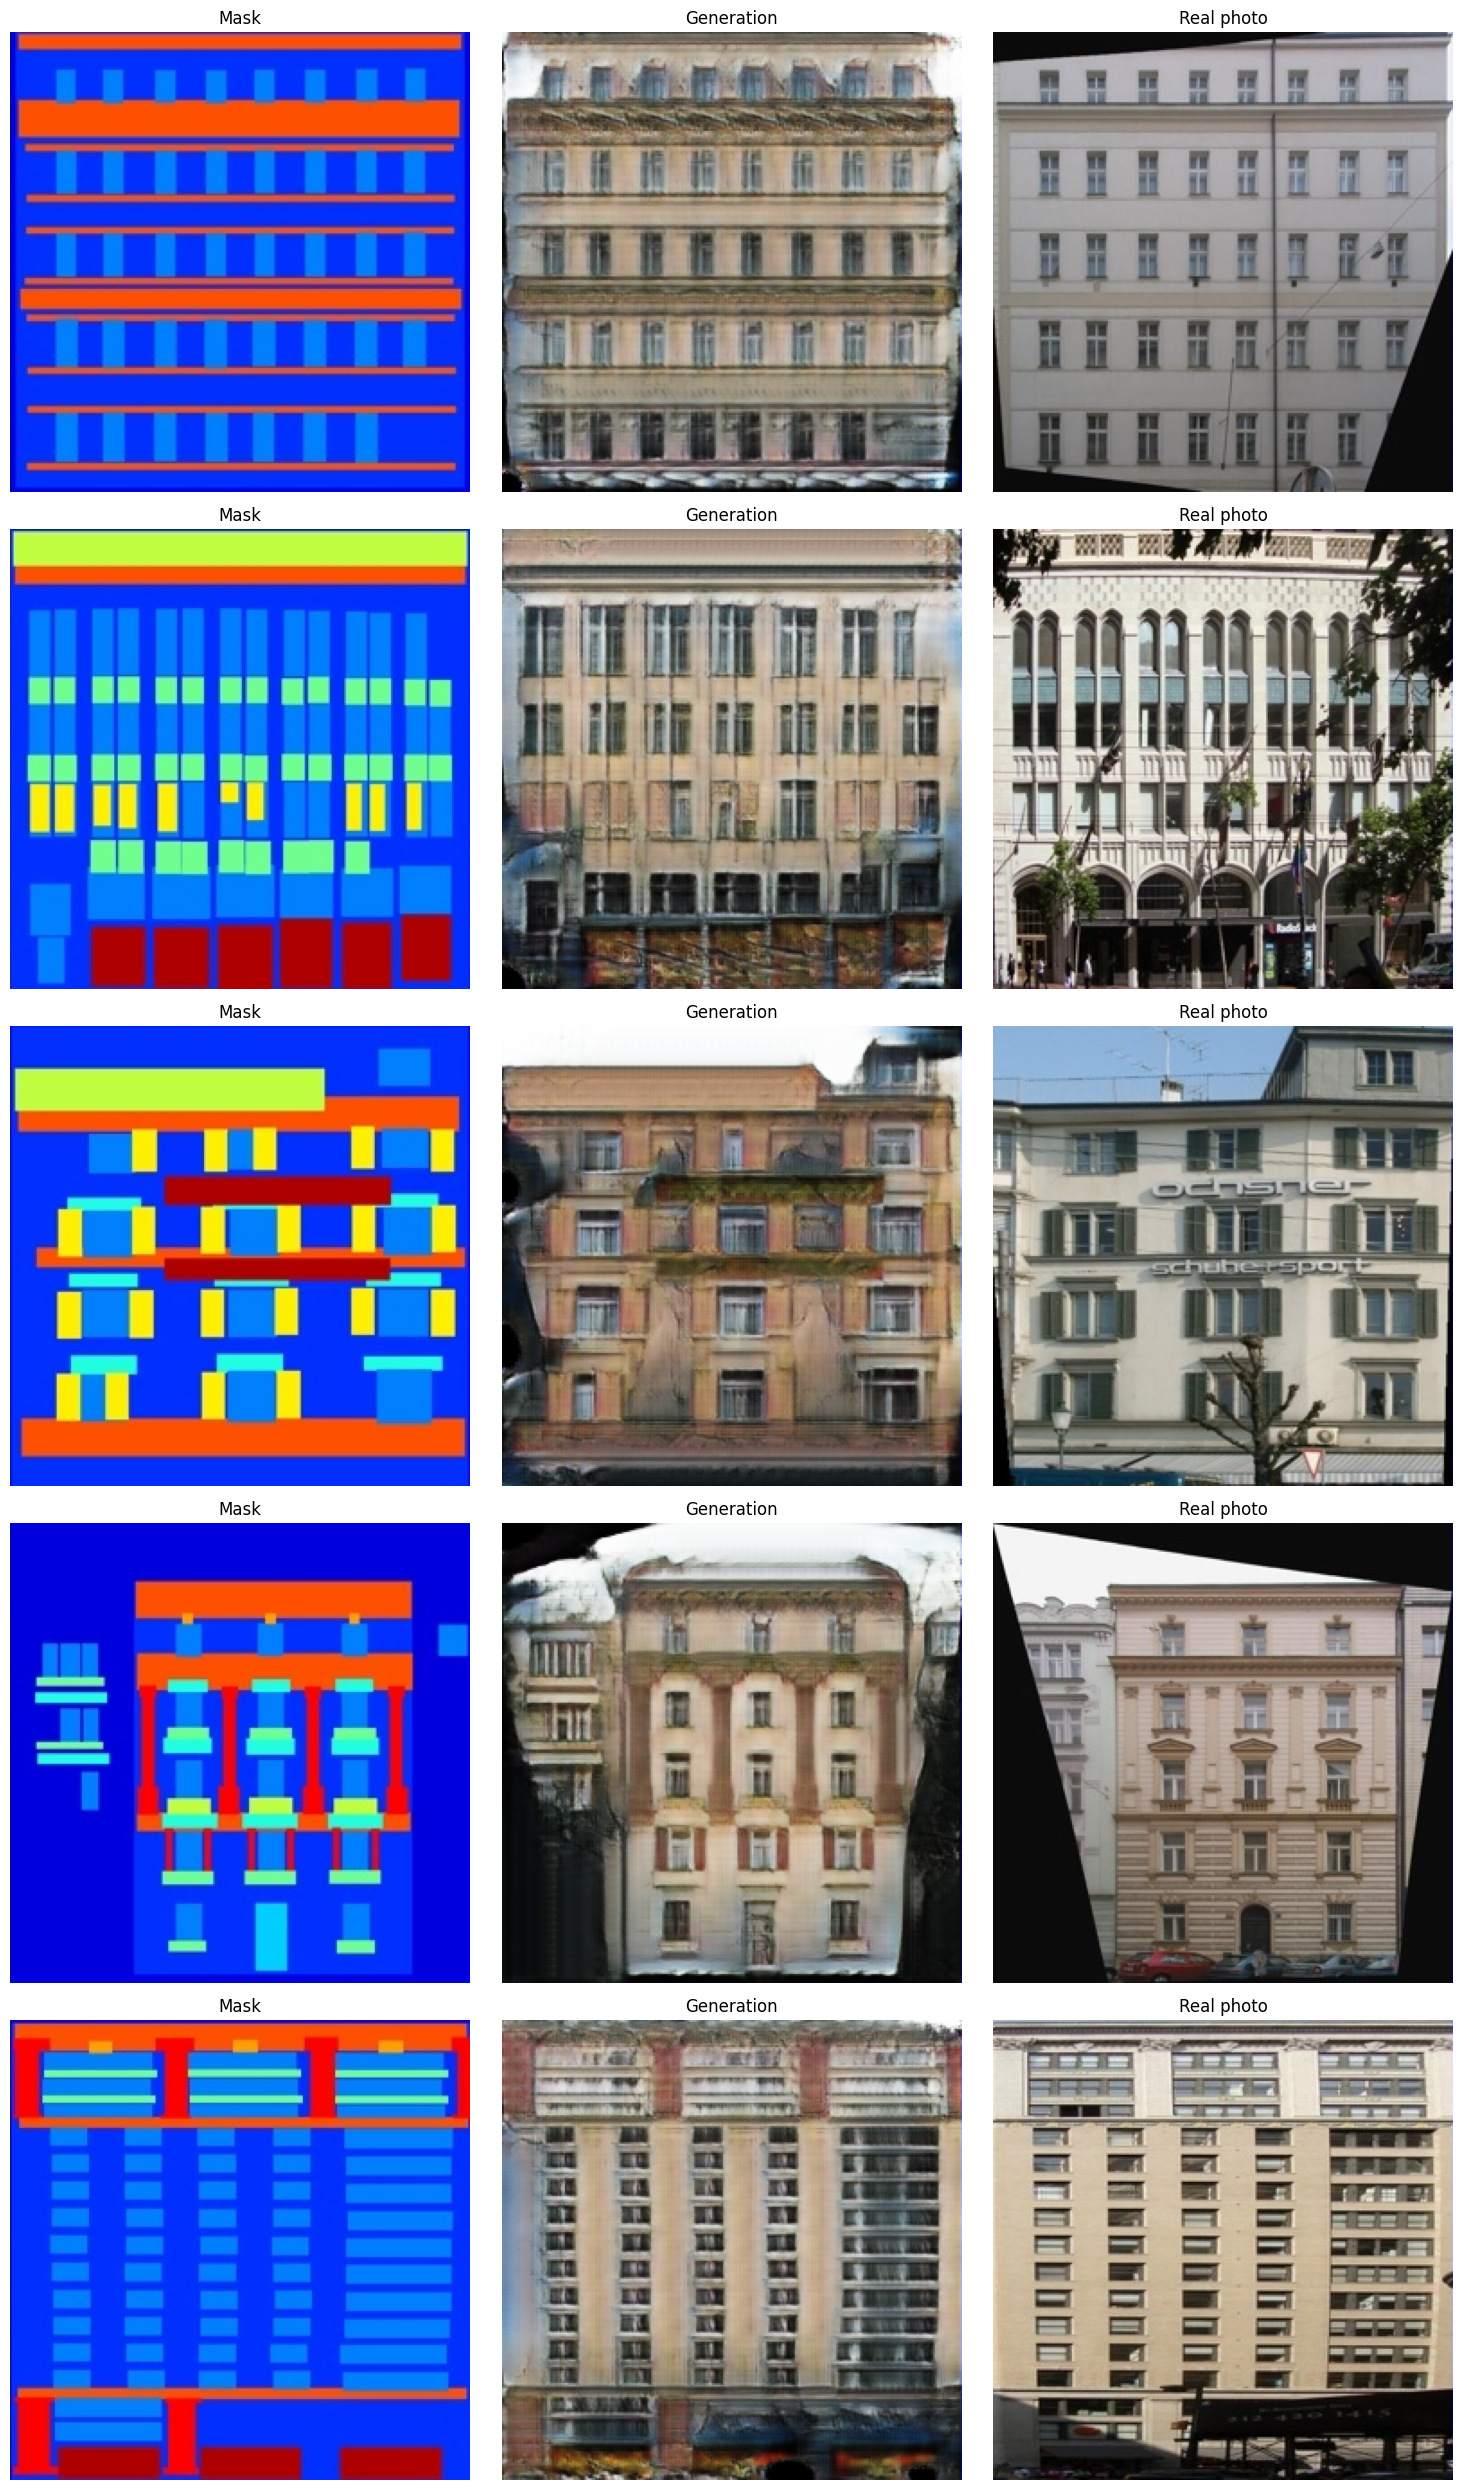

In [11]:
demonstrate_results("cyclegan_checkpoints/netG_epoch_100.pth", num_samples=5)

As you can see, the generated images look less blurred and have fewer artifacts than those generated by the pix2pix model.
This may be because CycleGAN introduces an additional limitation, cycle consistency loss. It requires that the image transformed from domain A to domain B and then back to A be as close as possible to the original. This forces the model to retain its structural features and reduces the likelihood of accidental artifacts.

Thus, due to the additional limitation of cyclic consistency and architectural features, CycleGAN generates images with less noise and artifacts.